In [8]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score

In [3]:
#Experimental Data
Temp = [1223.15, 1273.15, 1323.15, 1373.15, 1273.15, 1273.15]
Feed = [0.0024, 0.0024, 0.0024, 0.0024, 0.00024, 0.004]
exp = [0.830129146, 0.812426766, 0.785513487, 0.706470438, 0.690689298, 0.82341653]

In [4]:
def run_simulation(x,Tx,Fx):
    # Separate gas and interface multipliers
    gas_mult = x[0]
    cat_mult = x[1]
    # import the model for gas-Fe interface and adjacent gas phase
    cat = ct.Interface('FeSiO2_NOMC.yaml','Fe_surf')
    gas = cat.adjacent['gas']

    # Set gas phase reaction multiplier
    gas.set_multiplier(gas_mult)
    # Set cat phase reaction multiplier
    cat.set_multiplier(cat_mult)

    T0 = Tx # K
    p0 = ct.one_atm # atm
    gas.TPX = T0, p0, "CH4: 0.9, N2: 0.1"
    cat.TP = T0, p0
    D = 0.004 # diameter of the tube [m]
    Ac = np.pi * D**2 / 4 # cross section of the tube [m2]
    w_cat = 0.84 # weight of catalyst [gcat]
    GHSV = Fx # m3/gcat/hr
    u0 = GHSV * w_cat /3600 / Ac # [m/s]

    # Set the Reactor conditions
    reactor = ct.FlowReactor(gas)
    reactor.area = Ac
    reactor.mass_flow_rate = 0.704672614990904 * u0 * Ac
    reactor.energy_enabled = False
    rsurf = ct.ReactorSurface(cat, reactor)
    net = ct.ReactorNet([reactor])
    soln = ct.SolutionArray(gas, extra=['x', 'surf_coverages'])

    # Integrate the reactor network
    while net.distance < 0.06:
        net.step()
        wdot = rsurf.kinetics.net_production_rates
        soln.append(TDY=reactor.thermo.TDY,
                    x=net.distance,
                    surf_coverages=rsurf.coverages
        )
    return (0.704672614990904 * u0 * Ac,soln('CH4').Y[0][0],soln('CH4').Y[-1][0])


In [5]:
def objective(x):
    error = 0
    for i in range(len(Temp)):
    #     try:
    #         result = run_simulation(x,Temp[i],Feed[i])
    #         error += (result - exp[i])**2
    #     except Exception as e:
    #         error += 1e6
        result = run_simulation(x,Temp[i],Feed[i])
        error += (result[-1] - exp[i])**2
    return error

In [6]:
def Kinetic_Data(x,T,F):
    result = []
    for i in range(len(T)):
        res = run_simulation(x,T[i],F[i])
        WCH4i = res[0]*res[1]
        WCH4f = res[0]*res[2]
        X = (WCH4i - WCH4f)/WCH4i
        result.append(X)
    return result

In [21]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from itertools import product

x0 = np.linspace(5,5.1,30)
x1 = np.linspace(89,91,30)
xd = np.array(list(product(x0,x1)))
results = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(objective, x) for x in xd]

    for future in tqdm(futures, total=len(futures)):
        result = future.result()
        results.append(result)

print('처리 완료')

100%|██████████| 900/900 [13:22<00:00,  1.12it/s]

처리 완료


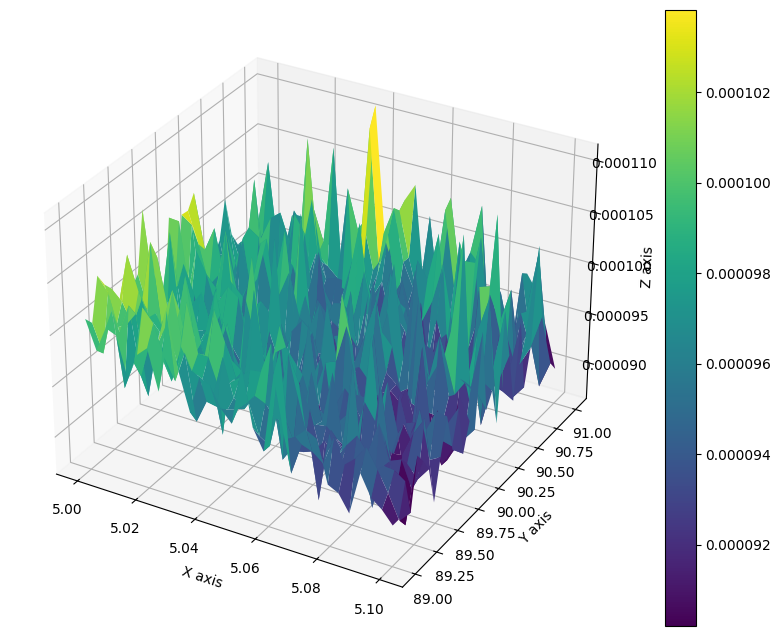

In [23]:
from mpl_toolkits.mplot3d import Axes3D

X = xd[:, 0].reshape(30, 30)
Y = xd[:, 1].reshape(30, 30)
Z = np.array(results).reshape(30,30)

# 그래프 생성
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# 표면 플롯
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# 축 레이블 설정
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# 컬러바 추가
fig.colorbar(surf)

# 그래프 표시
plt.show()

In [24]:
xd[np.argmin(results)]

array([ 5.08965517, 89.55172414])

In [25]:
Kinetic_Data(xd[np.argmin(results)],Temp,Feed)

[0.007028898934692658,
 0.020557661529244035,
 0.05952977450204265,
 0.15701779196952753,
 0.1775334851770946,
 0.012279617670768567]

In [18]:
result = Kinetic_Data([1,1],Temp,Feed)
exp = [0.008809,0.029946,0.062081,0.15646,0.175303,0.016824]

In [19]:
r2_score(exp,result)

-0.7115203991652552